# Imports

In [ ]:
<<<<<<< local
%load_ext autoreload
%autoreload 2
=======
>>>>>>> remote
import sys
import time

import numpy as np
import torch
from bnpm import file_helpers, optimization
import sklearn.utils.class_weight
from torch import nn, optim
from tqdm import tqdm
import sklearn.linear_model
import multiprocessing as mp

import roicat.classification.classifier_util as cu
import scipy.sparse
import roicat
import bnpm.h5_handling
from pathlib import Path
<<<<<<< local
=======
import sys
from pathlib import Path
>>>>>>> remote
import shutil
import warnings
import umap

import matplotlib.pyplot as plt
import matplotlib.offsetbox
<<<<<<< local
import json
import os
import natsort
from roicat import helpers
# from kymatio.torch import Scattering2D
import gc
import functools
=======
import json
>>>>>>> remote

# Specify Initial Parameters

<span style="color:red">**<<<<<<< local**</span>

In [2]:
directory_data_suite2pSearch = r'/Users/josh/analysis/data/ROICaT/classification/stat_s2p' # Place from which to load suite2p data
directory_save_labelOutputs = r'/Users/josh/analysis/outputs/ROICaT/classification/01_labels' # Place to dump Data object dict, ROINet object dict, Labels, and Parameters dict
testing = True
run_umap = True
filepath_umapModel = ''

In [3]:
directory_save = Path(directory_save_labelOutputs)
directory_save.mkdir(exist_ok=True, parents=True)

In [ ]:
pathSuffixToStat = 'stat.npy'
pathSuffixToOps = 'ops.npy'

paths_allStat = test = helpers.find_paths(
    dir_outer=directory_data_suite2pSearch,
    reMatch=pathSuffixToStat,
    depth=4,
)
paths_allOps = test = helpers.find_paths(
    dir_outer=directory_data_suite2pSearch,
    reMatch=pathSuffixToOps,
    depth=4,
)

print(paths_allStat)
print(paths_allOps)

#Import data
data = roicat.data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    um_per_pixel=2.0,
    new_or_old_suite2p='new',
    out_height_width=[36, 36],
    type_meanImg='meanImgE',
    verbose=True,
);

In [14]:
# Neural network embedding distances
roinet = roicat.ROInet.ROInet_embedder(
    device=roicat.util.helpers.set_device('cuda:0'),
    dir_networkFiles=r"/Users/josh/analysis/models",
    download_method="check_local_first",
    download_url="https://osf.io/xwzhp/download",
    download_hash="134b170242141c26b0adbd9e0fd80d0e",
    forward_pass_version="head",
    verbose=True,
)

roinet.generate_dataloader(
    ROI_images=data.ROI_images,
    um_per_pixel=data.um_per_pixel,
    pref_plot=False,
    batchSize_dataloader=8,
    pinMemory_dataloader=True,
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=True,
    prefetchFactor_dataloader=2,    
);

# roicat.visualization.display_toggle_image_stack(roinet.ROI_images_rs)

roinet.generate_latents();

gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()


/Users/josh/analysis/github_repos/ROICaT/roicat/util.py:191: UserWarning: RH WARNING: unable to get cpu info. Got error: No module named 'cpuinfo'
  warnings.warn(f'RH WARNING: unable to get cpu info. Got error: {e}')
/Users/josh/analysis/github_repos/ROICaT/roicat/util.py:210: UserWarning: RH WARNING: unable to get gpu info. Got error: No module named 'GPUtil'
  warnings.warn(f'RH WARNING: unable to get gpu info. Got error: {e}')


File already exists locally: /Users/josh/analysis/models/ROInet.zip
Hash of local file matches provided hash_hex.
Extracting /Users/josh/analysis/models/ROInet.zip to /Users/josh/analysis/models.
Completed zip extraction.
['/Users/josh/analysis/models/ROInet_classification_20220902', '/Users/josh/analysis/models/ROInet_classification_20220902/ConvNext_tiny__1_0_best__simCLR_wPCA.pth', '/Users/josh/analysis/models/ROInet_classification_20220902/model.py', '/Users/josh/analysis/models/ROInet_classification_20220902/classifier.pkl', '/Users/josh/analysis/models/ROInet_classification_20220902/params.json', '/Users/josh/analysis/models/ROInet_classification_20220902/__pycache__', '/Users/josh/analysis/models/ROInet_classification_20220902/__pycache__/model.cpython-39.pyc']
Imported model from /Users/josh/analysis/models/ROInet_classification_20220902/model.py
Loaded params_model from /Users/josh/analysis/models/ROInet_classification_20220902/params.json


/Users/josh/opt/anaconda3/envs/ROICaT/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/josh/opt/anaconda3/envs/ROICaT/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /Users/josh/analysis/models/ROInet_classification_20220902/ConvNext_tiny__1_0_best__simCLR_wPCA.pth
Loaded network onto device cpu
Starting: resizing ROIs
Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader
starting: running data through network


100%|██████████| 613/613 [09:41<00:00,  1.05it/s]


completed: running data through network


In [ ]:
# %matplotlib notebook
# dir_allOuterFolders = str(Path('/Users/josh/analysis/data/ROICaT/classification/raw_images').resolve())
dir_allOuterFolders = str(Path('/Users/josh/analysis/data/ROICaT/classification/stat_s2p').resolve())

pathSuffixToStat = 'stat.npy'
pathSuffixToOps = 'ops.npy'

paths_allStat = test = helpers.find_paths(
    dir_outer=dir_allOuterFolders,
    reMatch=pathSuffixToStat,
    depth=4,
)
paths_allOps = test = helpers.find_paths(
    dir_outer=dir_allOuterFolders,
    reMatch=pathSuffixToOps,
    depth=4,
)

display(paths_allStat)
display(paths_allOps)

#Import data
data = roicat.data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    um_per_pixel=2.0,
    new_or_old_suite2p='new',
    out_height_width=[36, 36],
    type_meanImg='meanImgE',
    verbose=True,
);

<span style="color:red">**=======**</span>

In [ ]:
path_params = None # Path(r"")
directory_save = r'/Users/josh/analysis/outputs/ROICaT/classification/01_labels'
testing = True
save_ROIs = True
save_latents = True

In [ ]:
directory_save = Path(directory_save)
directory_save.mkdir(exist_ok=True, parents=True)

labelingRun_interim = {}

if path_params is not None:
    try:
        Path(str((directory_save).resolve())).mkdir(exist_ok=True, parents=True)
        shutil.copy2(path_params, str(Path(directory_save) / Path(path_params).name));
    except Exception as e:
        print(f'JZ: Error copying params to {directory_save}')
        print(e)
tic = time.time()
tictoc = {}
tictoc['start'] = time.time() - tic

params = file_helpers.json_load(str(Path(path_params).resolve())) if path_params is not None else None

In [5]:
if params is None:
    params = {
        "method": "simclr",
        "device": "cuda:0",
        "datatype": "raw_images",
        "hyperparameters_data": {
            "new_or_old_suite2p": "new",
            "out_height_width": [
                36,
                36
            ],
            "type_meanImg": "meanImgE",
            "FOV_images": None,
            "verbose": True,
            "um_per_pixel": 2.0
        },
        "hyperparameters_split": {
            "n_train": 50000,
            "test_size": 0.3
        },
        "paths": {
            "directory_github": "/Users/josh/analysis/github_repos/",
            "directory_data": "/Users/josh/analysis/data/ROICaT/classification/raw_images",
            "filename_rawImages": "sf_concat_rs_sparse.npz",
            "filename_labels": "labels.npy",
            "directory_simclrModel": "/Users/josh/analysis//models",
            "filepath_umapModel": None,
        },
        "hyperparameters_training_simclr": {
            "num_transform_copies": 80,
            "solver": "lbfgs",
            "fit_intercept": True,
            "max_iter": 20000,
            "C": 0.01,
            "tol": 0.001,
            "simclrModel_download_url": "https://osf.io/xwzhp/download",
            "simclrModel_download_hash": "134b170242141c26b0adbd9e0fd80d0e"
        },
        "hyperparameters_augmentations_val": {
            "Scale_image_sum": {
                "sum_val": 1,
                "epsilon": 1e-09,
                "min_sub": True
            },
            "ScaleDynamicRange": {
                "scaler_bounds": [
                    0,
                    1
                ],
                "epsilon": 1e-09
            },
            "WarpPoints": {
                "r": [
                    0.1,
                    0.2
                ],
                "cx": [
                    -0.3,
                    0.3
                ],
                "cy": [
                    -0.3,
                    0.3
                ],
                "dx": [
                    -0.1,
                    0.1
                ],
                "dy": [
                    -0.1,
                    0.1
                ],
                "n_warps": 1,
                "prob": 0.0,
                "img_size_in": [
                    36,
                    36
                ],
                "img_size_out": [
                    224,
                    224
                ]
            },
            "TileChannels": {
                "dim": -3,
                "n_channels": 3
            }
        },
        "run_umap": True,
    }

if not torch.cuda.is_available() and params['device'] != 'cpu':
    warnings.warn('CUDA not available, using CPU')
    params['device'] = torch.device('cpu')

/var/folders/gb/td_6747j3_z81x0r_38hyw180000gn/T/ipykernel_11465/2586939875.py:93: UserWarning: CUDA not available, using CPU
  warnings.warn('CUDA not available, using CPU')


# Import Datasets

In [6]:
directory_model = str(Path(params['paths']['directory_model']).resolve()) if 'directory_model' in params['paths'] else None
filepath_data_labels = str((Path(params['paths']['directory_data']) / params['paths']['filename_labels']).resolve())

if params['datatype'] == "stat_s2p":
    assert 'filename_stat' in params['paths'] and 'filename_ops' in params['paths'], 'JZ: The suite2p params.json file must include paths.filename_stat and paths.filename_ops for stat_s2p datatype'
    filepath_data_stat = str((Path(params['paths']['directory_data']) / params['paths']['filename_stat']).resolve())
    filepath_data_ops = str((Path(params['paths']['directory_data']) / params['paths']['filename_ops']).resolve())

    # Create data importing object to import suite2p data
    data = roicat.data_importing.Data_suite2p(
        paths_statFiles=[filepath_data_stat],
        paths_opsFiles=[filepath_data_ops],
        class_labels=[filepath_data_labels],
        um_per_pixel=params['hyperparameters_data']['um_per_pixel'],
        new_or_old_suite2p=params['hyperparameters_data']['new_or_old_suite2p'],
        out_height_width=params['hyperparameters_data']['out_height_width'],
        type_meanImg=params['hyperparameters_data']['type_meanImg'],
        FOV_images=params['hyperparameters_data']['FOV_images'],
        verbose=params['hyperparameters_data']['verbose'],
    )
elif params['datatype'] == "raw_images":
    assert 'filename_rawImages' in params['paths'], 'JZ: The suite2p params.json file must include paths.filename_rawImages for raw_images datatype'
    filepath_data_rawImages = str((Path(params['paths']['directory_data']) / params['paths']['filename_rawImages']).resolve())

    sf = scipy.sparse.load_npz(filepath_data_rawImages)
    labels = np.load(filepath_data_labels)

    data = roicat.data_importing.Data_roicat(verbose=True)
    data.set_ROI_images(ROI_images=[sf.A.reshape(sf.shape[0], 36, 36)], um_per_pixel=params['hyperparameters_data']['um_per_pixel'])
    data.set_class_labels(class_labels=[labels.astype(int)])
else:
    raise ValueError(f"Invalid datatype for simclr: {params['datatype']}")

Starting: Importing ROI images
Completed: Imported 1 sessions. Each session has [68382] ROIs. Total number of ROIs is 68382. The um_per_pixel is 2.0 um per pixel.
Starting: Importing class labels
Labels and ROI Images match in shapes: Class labels and ROI images have the same number of sessions and the same number of ROIs in each session.
Completed: Imported labels for 1 sessions. Each session has [68382] class labels. Total number of class labels is 68382.


# Filter Dataset

In [7]:
tictoc['imported_data'] = time.time() - tic

ROI_images_rescaled = [roicat.ROInet.ROInet_embedder.resize_ROIs(rois, params['hyperparameters_data']['um_per_pixel']) for rois in data.ROI_images]

# Initialize concatendated data
ROI_images_init = np.concatenate(data.ROI_images, axis=0).astype(np.float32)
ROI_images_init_rescaled = np.concatenate(ROI_images_rescaled, axis=0).astype(np.float32)
_labels_init = np.concatenate(data.class_labels, axis=0).astype(int).copy()

inx_kept = np.arange(ROI_images_init_rescaled.shape[0])

# Perform data cleaning
idx_violations = (np.isnan(ROI_images_init_rescaled.sum(axis=(1,2)))*1 + (np.sum(ROI_images_init_rescaled, axis=(1,2))==0)*1 + np.isnan(_labels_init)) != 0
print('Number of idx_violations: ', idx_violations.sum(), ' out of ', len(idx_violations), ' total ROIs.')
print('Located at: ', np.where(idx_violations)[0])
print('Discarding these ROIs...')

inx_kept = inx_kept[~idx_violations]
ROI_images_filt = ROI_images_init_rescaled[~idx_violations]
_labels_filt = _labels_init[~idx_violations]

if testing:
    inx_kept = inx_kept[:100]
    ROI_images_filt = ROI_images_filt[:100]
    _labels_filt = _labels_filt[:100]

labelingRun_interim['inx_kept'] = inx_kept
labelingRun_interim['ROI_images_filt'] = ROI_images_filt

## No remapping for generate preproc
# labels_remapped = cu.remap_labels(labels_filt, params['label_remapping'])

tictoc['cleaned_data'] = time.time() - tic

print(f'Shape of ROI_images_filt: {ROI_images_filt.shape}, shape of labels_remapped: {_labels_filt.shape}')

Number of idx_violations:  2  out of  68382  total ROIs.
Located at:  [41927 62784]
Discarding these ROIs...
Shape of ROI_images_filt: (100, 36, 36), shape of labels_remapped: (100,)


# Pass Data Through Network

In [8]:
transforms_final_val = cu.get_transforms(params['hyperparameters_augmentations_val'], scripted=True)
dataset_val = roicat.ROInet.dataset_simCLR(
        X=torch.as_tensor(ROI_images_filt, device='cpu', dtype=torch.float32),
        y=torch.as_tensor(np.zeros((ROI_images_filt.shape[0])), device='cpu', dtype=torch.float32),
        n_transforms=1,
        class_weights=np.array([1]),
        transform=transforms_final_val, # *Use WarpPoints
        DEVICE='cpu',
        dtype_X=torch.float32,
    )
dataloader_val = torch.utils.data.DataLoader( 
        dataset_val,
        batch_size=64,
        shuffle=False,
        drop_last=False,
        pin_memory=False,
        num_workers=0,#mp.cpu_count(),
        persistent_workers=False,
        prefetch_factor=2,
)

roinet = roicat.ROInet.ROInet_embedder(
    device=params['device'],
    dir_networkFiles=params['paths']['directory_simclrModel'],
    download_method='check_local_first',
    forward_pass_version='head',
    download_url=params['hyperparameters_training_simclr']['simclrModel_download_url'],
    download_hash=params['hyperparameters_training_simclr']['simclrModel_download_hash'],
    verbose=True,
)

print(f'Extracting transformed images from dataloaders, passing through roinet model, and saving to {directory_save}...')

features_val, _labels_val, _idx_val, _sample_val = cu.extract_with_dataloader(
    dataloader_val,
    model=roinet.net,
    num_copies=1,
    device=params['device'],
)

labelingRun_interim['features_val'] = features_val
print(f'Unaugmented run completed.')

<span style="color:red">**>>>>>>> remote**</span>

# Run 2D UMap OR Project onto Previousy Fit UMap for Hand Labeling

<span style="color:red">**<<<<<<< local**</span>

Fitting UMAP...
Unspecified filepath_umapModel in params... not saving UMAP to file.
Generating Embeddings...
Embeddings Generated...


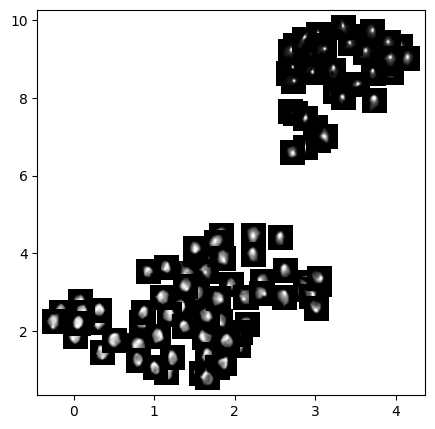

In [8]:
umap_model = cu.Hand_Labeler()
print('Generating Embeddings...')
embeddings = umap_model.transform(roinet.latents)
print('Embeddings Generated...')
%matplotlib inline
umap_model.plot_annotated(data, embeddings)

# TODO: JZ, Add Circling Code for Labeling
if testing:
    num_zeroLabels = np.concatenate(data.ROI_images).shape[0]//2
    num_onesLabels = np.concatenate(data.ROI_images).shape[0] - np.concatenate(data.ROI_images).shape[0]//2
    arr_labels = np.concatenate([np.zeros(num_zeroLabels), np.ones(num_onesLabels)])
else:
    raise NotImplementedError('Saving UMAP to file not yet implemented.') # TODO: JZ, Implement saving UMAP to file

<span style="color:red">**=======**</span>

In [ ]:
if params['run_umap']:
    umap_params = dict(
        n_neighbors=30,
        n_components=2,
        metric='euclidean',
        metric_kwds=None,
        output_metric='euclidean',
        output_metric_kwds=None,
        n_epochs=None,
        learning_rate=1.0,
        init='spectral',
        min_dist=0.1,
        spread=1.0,
        low_memory=True,
        n_jobs=-1,
        set_op_mix_ratio=1.0,
        local_connectivity=1.0,
        repulsion_strength=1.0,
        negative_sample_rate=5,
        transform_queue_size=4.0,
        a=None,
        b=None,
        random_state=None,
        angular_rp_forest=False,
        target_n_neighbors=-1,
        target_metric='categorical',
        target_metric_kwds=None,
        target_weight=0.5,
        transform_seed=42,
        transform_mode='embedding',
        force_approximation_algorithm=False,
        verbose=False,
        tqdm_kwds=None,
        unique=False,
        densmap=False,
        dens_lambda=2.0,
        dens_frac=0.3,
        dens_var_shift=0.1,
        output_dens=False,
        disconnection_distance=None,
        precomputed_knn=(None, None, None),
    )

    umap = umap.UMAP(**umap_params)
    print('Fitting UMAP...')
    umap.fit(features_val)

    if params['paths']['filepath_umapModel']:
        raise NotImplementedError('Saving UMAP to file not yet implemented.') # TODO: JZ, Implement saving UMAP to file
        # print(f'Saving UMAP to {params["paths"]["filepath_umapModel"]}...')
        # joblib.dump(umap, params['paths']['filepath_umapModel'])
    else:
        print('Unspecified filepath_umapModel in params... not saving UMAP to file.')
elif params['paths']['filepath_umapModel']:
    raise NotImplementedError('Loading UMAP from file not yet implemented.') # TODO: JZ, Implement loading UMAP from file
    # print(f'Loading UMAP from {params["paths"]["filepath_umapModel"]}...')
    # umap = joblib.load(params['paths']['filepath_umapModel'])
else:
    raise ValueError(f'run_umap must be True or filepath_umapModel must be specified in params.')

print('Generating Embeddings...')
embeddings = umap.transform(features_val)
labelingRun_interim['embeddings'] = embeddings
print('Embeddings Generated...')
%matplotlib inline
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(embeddings[:,0], embeddings[:,1], s=5, cmap='gist_rainbow')

# inx_lst = list(range(100))
inx_lst = np.arange(ROI_images_filt.shape[0])
img_lst = ROI_images_filt[inx_lst]
x = embeddings[inx_lst, 0]
y = embeddings[inx_lst, 1]

for x0, y0, ROI_single in zip(x, y, img_lst):
    offsetImage = matplotlib.offsetbox.OffsetImage(ROI_single, cmap='gray', zoom=0.5) # initialize offset image to contain ROI visualization
    ab = matplotlib.offsetbox.AnnotationBbox(offsetImage, (x0, y0), frameon=False)
    ax.add_artist(ab)

# TODO: JZ, Add Circling Code for Labeling
if testing:
    num_zeroLabels = ROI_images_filt.shape[0]//2
    num_onesLabels = ROI_images_filt.shape[0] - ROI_images_filt.shape[0]//2
    arr_labels = np.concatenate([np.zeros(num_zeroLabels), np.ones(num_onesLabels)])
else:
    raise NotImplementedError('Saving UMAP to file not yet implemented.') # TODO: JZ, Implement saving UMAP to file

<span style="color:red">**>>>>>>> remote**</span>

# Save Outputs

<span style="color:red">**<<<<<<< local**</span>

In [26]:
with open(str((Path(directory_save) / 'feature_label_combo.npy').resolve()), 'wb') as f:
    np.save(
        file=f,
        arr={
            'rois': data.ROI_images,
            'latents': roinet.latents,
            'embeddings': embeddings,
            'labels': arr_labels,
        },
        allow_pickle=True,
    )
with open(str((Path(directory_save) / 'pkl_labelingRunInterim.npy').resolve()), 'wb') as f:
    np.save(
        file=f,
        arr=labelingRun_interim,
        allow_pickle=True
    )

print(f'Saving files completed.')

Saving files completed.


<span style="color:red">**=======**</span>

In [20]:
with open(str((Path(directory_save) / 'arr_labels.npy').resolve()), 'wb') as f:
    np.save(
        file=f,
        arr=arr_labels,
    )

if save_ROIs:
    with open(str((Path(directory_save) / 'arr_ROIs.npy').resolve()), 'wb') as f:
        np.save(
            file=f,
            arr=features_val,
        )

if save_latents:
    with open(str((Path(directory_save) / 'arr_latents.npy').resolve()), 'wb') as f:
        np.save(
            file=f,
            arr=features_val,
        )

labelingRun_interim['params_prespecified'] = params
with open(str((Path(directory_save) / 'pkl_labelingRunInterim.npy').resolve()), 'wb') as f:
    np.save(
        file=f,
        arr=labelingRun_interim,
        allow_pickle=True
    )

print(f'Saving files completed.')


Saving files completed.


<span style="color:red">**>>>>>>> remote**</span>